[View in Colaboratory](https://colab.research.google.com/github/peaelle42/DNN_jump_start/blob/master/JS03_06_1_Transfer_Learning.ipynb)

## Testing for GPU 


To Test if you have GPU set up

Run the Cell below

if no GPU is found press Runtime (in the menu at the top) and choose "Change Runtime Type" to GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
!ls

datalab


In [3]:
!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip


!unzip -qq utils.zip
!rm utils.zip
!rm -r __MACOSX

!ls

datalab  gdrive.py  sutils.py


In [4]:
!ls

datalab  gdrive.py  sutils.py


In [5]:
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline
from sutils import *
import os, json
from glob import glob

from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.applications import nasnet

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
from tensorflow.python.keras import backend as K

import tensorflow as tf


Using TensorFlow backend.


In [6]:
print(tf.keras.__version__)
print(tf.__version__)

2.1.6-tf
1.9.0-rc2


In [0]:
limit_gpu_mem()

## Download the dataset

In [8]:
!wget -qq https://www.dropbox.com/s/bgv2q2isj6fni5o/data.zip
  
!unzip -qq data.zip
!rm data.zip
!rm -r __MACOSX

!ls

data  datalab  gdrive.py  __pycache__  sutils.py


In [9]:
!ls data

dogscats  imagenet


In [0]:
path = "./data/dogscats/"
#path = "./data/dogscats/sample/"

In [0]:
img_width, img_height = 299, 299
train_data_dir = "./data/dogscats/train/"
validation_data_dir = "./data/dogscats/valid/"

nb_train_samples = 4125
nb_validation_samples = 2000 
batch_size = 16
epochs = 5

In [12]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
# Prepare images for training in batches
# NB: They must be in subdirectories named based on their category
#batches = get_batches(path+'train', batch_size=batch_size)
#val_batches = get_batches(path+'valid', batch_size=batch_size*2)

This will download the Inception weights from
https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [14]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

#base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 7s 0us/step


In [15]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 2 classes
predictions = Dense(2, activation='softmax')(x)


In [0]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False


input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [19]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d
False
batch_normalization
False
activation
False
conv2d_1
False
batch_normalization_1
False
activation_1
False
conv2d_2
False
batch_normalization_2
False
activation_2
False
max_pooling2d
False
conv2d_3
False
batch_normalization_3
False
activation_3
False
conv2d_4
False
batch_normalization_4
False
activation_4
False
max_pooling2d_1
False
conv2d_8
False
batch_normalization_8
False
activation_8
False
conv2d_6
False
conv2d_9
False
batch_normalization_6
False
batch_normalization_9
False
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_5
False
conv2d_7
False
conv2d_10
False
conv2d_11
False
batch_normalization_5
False
batch_normalization_7
False
batch_normalization_10
False
batch_normalization_11
False
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_15
False
batch_normalization_15
False
activation_15
False
conv2d_13
False
conv2d_16
False
batch_normalization_13
False
batch_normalization_16
False
activati

In [0]:
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:

batch_test = train_generator.next()

print(len(batch_test[1][0]))
print(len(batch_test[0][0]))
batch_test[1][2]

2
299


array([0., 1.], dtype=float32)

In [22]:
# Train the model 
model.fit_generator( train_generator, steps_per_epoch = 80,
epochs = epochs,
validation_data = validation_generator,
validation_steps = 10)

Epoch 1/5
80/80 [==============================] - 52s 650ms/step - loss: 0.3947 - acc: 0.8484 - val_loss: 0.0659 - val_acc: 0.9781
Epoch 2/5
80/80 [==============================] - 45s 561ms/step - loss: 0.1851 - acc: 0.9266 - val_loss: 0.1289 - val_acc: 0.9594
Epoch 3/5
80/80 [==============================] - 45s 564ms/step - loss: 0.2262 - acc: 0.9195 - val_loss: 0.1284 - val_acc: 0.9688
Epoch 4/5
80/80 [==============================] - 45s 562ms/step - loss: 0.2227 - acc: 0.9234 - val_loss: 0.1465 - val_acc: 0.9500
Epoch 5/5
11/80 [===>..........................] - ETA: 14s - loss: 0.3050 - acc: 0.9034

80/80 [==============================] - 45s 564ms/step - loss: 0.1770 - acc: 0.9344 - val_loss: 0.1061 - val_acc: 0.9563


In [23]:
metrics = model.evaluate_generator(validation_generator,10,10,workers=1)
print("model accuracy:",metrics[1])

model accuracy: 0.95


In [0]:
model.save('cats-dogs.hdf5')

In [0]:
model = load_model('cats-dogs.hdf5')

In [0]:
image_path = './data/dogscats/test1/'

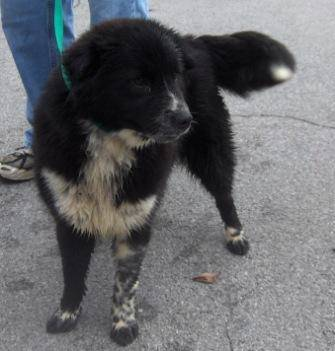

In [73]:
from IPython.display import Image

image_check = '298.jpg'

Image(image_path+image_check)

In [74]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_check)
print(img_path)
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

./data/dogscats/test1/298.jpg
Input image shape: (1, 224, 224, 3)


In [75]:
preds = model.predict(x)
print('Predicted:', preds)

Predicted: [[1.732669e-31 1.000000e+00]]


In [72]:
result= preds[0][0]
if result< preds[0][1]:
    print("It's a cat")
else:
    print("It's a dog")

It's a cat


2.3603672e-09

2.3603672e-09

2.3603672e-09

In [0]:
!kill -9 -1